In [1]:
# Cell 1: Imports and Setup
import os
import random
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, roc_auc_score
from torchvision.models import ResNet18_Weights
from torchvision.models import ResNet34_Weights
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import models, transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
import cv2

# Set up logging
logging.basicConfig(filename='training.log', level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')

# Set random seed for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f"Using device: {device}")
print(f"Using device: {device}")

# Create models directory if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')

# Generate a random name for this run
def generate_random_name():
    adjectives = ['swift', 'bold', 'clever', 'dapper', 'eager', 'fierce', 'gentle', 'happy', 'jolly', 'kind']
    nouns = ['panda', 'eagle', 'tiger', 'dolphin', 'koala', 'falcon', 'wolf', 'owl', 'fox', 'bear']
    return f"{random.choice(adjectives)}_{random.choice(nouns)}_{random.randint(1000, 9999)}"

run_name = generate_random_name()
print(f"Run name: {run_name}")

# Create a directory for this run if it doesn't exist
run_dir = os.path.join('runs', run_name)
if not os.path.exists(run_dir):
    os.makedirs(run_dir)

# Set up logging to write to a file in the run directory
log_file = os.path.join(run_dir, f'{run_name}.log')
logging.basicConfig(filename=log_file, level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')

logging.info(f"Run name: {run_name}")
logging.info(f"Run directory: {run_dir}")

Using device: cpu
Run name: bold_panda_5506


Train class distribution: {0: 92, 1: 19}
Validation class distribution: {0: 23, 1: 5}
Train set size: 111, Validation set size: 28
Displaying sample images from the training set:


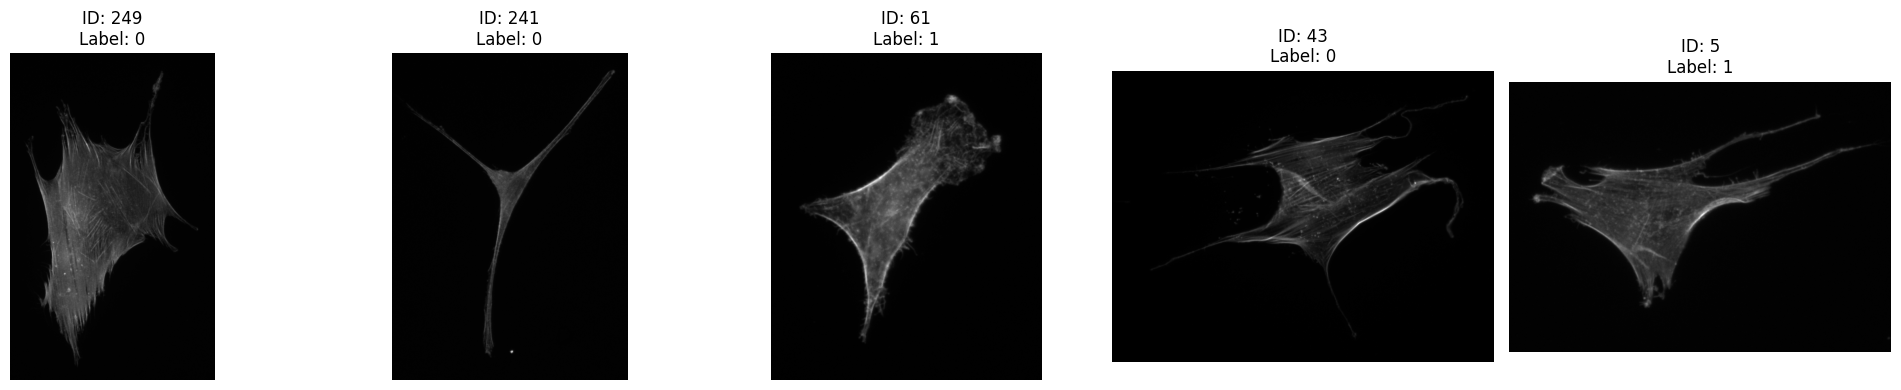

In [2]:
# Cell 2: Data Loading and Preprocessing
def load_and_preprocess_data(csv_path, images_dir):
    df = pd.read_csv(csv_path)
    logging.info(f"Loaded dataframe with shape: {df.shape}")
    
    # Clean up the data
    df['image_id'] = df['image_id '].astype(str).str.strip()
    df['label'] = df['is_homogenous'].astype(int)
    df = df.drop(columns=['is_homogenous'])

    def load_image(image_id):
        img_path = os.path.join(images_dir, f"{str(image_id).zfill(3)}.tif")
        if not os.path.exists(img_path):
            print(f"Warning: Image file not found: {img_path}")
            return None
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        if img is None:
            print(f"Error: Unable to read image: {img_path}")
        return img

    df['image_array'] = df['image_id'].apply(load_image)
    
    # Count class distribution
    class_counts = df['label'].value_counts()
    logging.info(f"Class distribution: {class_counts.to_dict()}")
    
    return df, class_counts

# Load and preprocess data
csv_path = 'data/training.csv'
images_dir = 'data/training'
df, class_counts = load_and_preprocess_data(csv_path, images_dir)

# Split data
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Log sizes of train and validation distributions
logging.info(f"Train set size: {len(train_df)}, Validation set size: {len(val_df)}")
logging.info(f"Train class distribution: {train_df['label'].value_counts().to_dict()}")
logging.info(f"Validation class distribution: {val_df['label'].value_counts().to_dict()}")
print(f"Train class distribution: {train_df['label'].value_counts().to_dict()}")
print(f"Validation class distribution: {val_df['label'].value_counts().to_dict()}")
print(f"Train set size: {len(train_df)}, Validation set size: {len(val_df)}")

# Function to display sample images
def show_samples(dataframe, num_samples=5):
    plt.figure(figsize=(20, 4))
    samples = dataframe.sample(num_samples)
    for i, (_, row) in enumerate(samples.iterrows()):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(row['image_array'], cmap='gray')
        plt.title(f"ID: {row['image_id']}\nLabel: {row['label']}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show samples from the training set
print("Displaying sample images from the training set:")
show_samples(train_df)

Displaying transformed sample images from the training set:


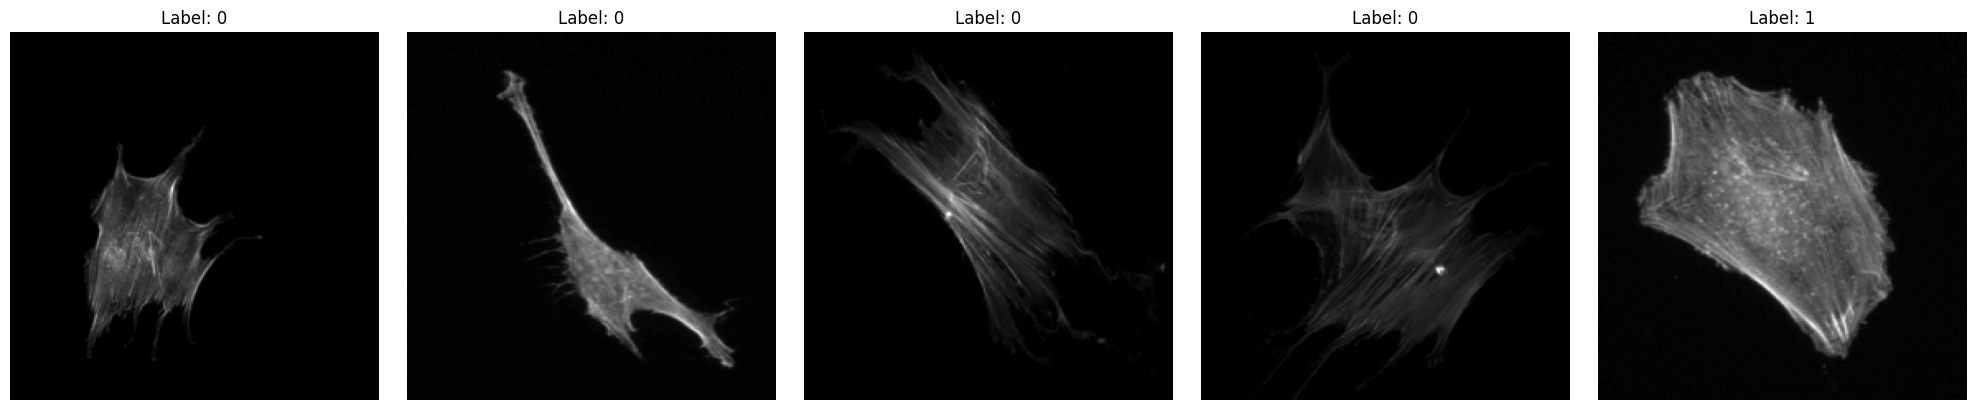

Length of train_dataset: 184
Length of val_dataset: 28
Proportion of minority class in train_dataset: 0.5
Proportion of minority class in val_dataset: 0.17857142857142858


In [3]:
class BalancedCellDataset(Dataset):
    def __init__(self, dataframe, transform=None, minority_transform=None, balance=True):
        self.original_dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
        self.minority_transform = minority_transform
        self.balance = balance
        
        self.augmentations = [
            transforms.RandomHorizontalFlip(p=1),
            transforms.RandomVerticalFlip(p=1),
            transforms.RandomRotation(degrees=15)
        ]

        # Always resize images
        self.resize = transforms.Resize((224, 224))

        if self.balance:
            self.dataframe = self.balance_classes()
        else:
            self.dataframe = self.original_dataframe

    def balance_classes(self):
        majority_class = self.original_dataframe['label'].value_counts().index[0]
        minority_class = self.original_dataframe['label'].value_counts().index[1]
        
        majority_samples = self.original_dataframe[self.original_dataframe['label'] == majority_class]
        minority_samples = self.original_dataframe[self.original_dataframe['label'] == minority_class]
        
        # Oversample minority class
        minority_oversampled = minority_samples.sample(len(majority_samples), replace=True, random_state=42)
        
        return pd.concat([majority_samples, minority_oversampled]).reset_index(drop=True)

    def __getitem__(self, idx):
        img_array = self.dataframe.iloc[idx]['image_array']
        label = self.dataframe.iloc[idx]['label']

        if img_array is None:
            print(f"Warning: Image at index {idx} is None. Skipping this image.")
            return None, label

        # Convert numpy array to the correct format for PIL Image
        if img_array.dtype == np.uint16:
            img_array = (img_array / 256).astype(np.uint8)
        elif img_array.dtype != np.uint8:
            img_array = ((img_array - img_array.min()) / (img_array.max() - img_array.min()) * 255).astype(np.uint8)

        # Convert numpy array to PIL Image
        img = Image.fromarray(img_array, mode='L')  # 'L' mode for grayscale

        # Always resize the image
        img = self.resize(img)

        if label == 1:  # Minority class (homogenous samples)
            aug_choice = random.randint(0, len(self.augmentations))
            if aug_choice < len(self.augmentations):
                img = self.augmentations[aug_choice](img)
            
            if self.minority_transform:
                img = self.minority_transform(img)
        elif self.transform:
            img = self.transform(img)

        # Ensure the image is a tensor
        if not isinstance(img, torch.Tensor):
            to_tensor = transforms.ToTensor()
            img = to_tensor(img)

        return img, label

    def __len__(self):
        return len(self.dataframe)

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

minority_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

# Create datasets and dataloaders
train_dataset = BalancedCellDataset(train_df, transform=transform, minority_transform=minority_transform, balance=True)
val_dataset = BalancedCellDataset(val_df, transform=transform, balance=False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

# Function to display transformed images
def show_transformed_samples(dataset, num_samples=5):
    plt.figure(figsize=(20, 4))
    for i in range(num_samples):
        img, label = dataset[random.randint(0, len(dataset)-1)]
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img.squeeze().numpy(), cmap='gray')
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show transformed samples from the training set
print("Displaying transformed sample images from the training set:")
show_transformed_samples(train_dataset)

print(f"Length of train_dataset: {len(train_dataset)}")
print(f"Length of val_dataset: {len(val_dataset)}")
print(f"Proportion of minority class in train_dataset: {train_dataset.dataframe['label'].mean()}")
print(f"Proportion of minority class in val_dataset: {val_dataset.dataframe['label'].mean()}")


In [4]:
# Cell 4: Data Visualization
def plot_sample_images(dataset, num_samples=5, title="Sample Images"):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        idx = random.randint(0, len(dataset) - 1)
        img, label = dataset[idx]
        
        if img is None:
            print(f"Warning: Image at index {idx} is None. Skipping this image.")
            continue
        
        if isinstance(img, torch.Tensor):
            img = img.permute(1, 2, 0).numpy()
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig(os.path.join(run_dir, f'{title.lower().replace(" ", "_")}.png'))
    plt.close()

# Plot pre-transform images
plot_sample_images(train_dataset, title="Pre-transform Train Images")
plot_sample_images(val_dataset, title="Pre-transform Validation Images")

# Create transformed datasets for post-transform images
transformed_train_dataset = BalancedCellDataset(train_df, transform=transform)
transformed_val_dataset = BalancedCellDataset(val_df, transform=transform)

# Plot post-transform images
plot_sample_images(transformed_train_dataset, title="Post-transform Train Images")
plot_sample_images(transformed_val_dataset, title="Post-transform Validation Images")

In [5]:
# Cell 5: Model Definition and Training
def calculate_custom_score(y_true, y_pred):
    n0 = sum(1 for label in y_true if label == 0)
    n1 = sum(1 for label in y_true if label == 1)
    a0 = sum(1 for true, pred in zip(y_true, y_pred) if true == 0 and pred == 0)
    a1 = sum(1 for true, pred in zip(y_true, y_pred) if true == 1 and pred == 1)
    return (a0 * a1) / (n0 * n1) if (n0 * n1) != 0 else 0

def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=20, patience=5):
    train_losses, train_accuracies, train_scores = [], [], []
    val_losses, val_accuracies, val_scores = [], [], []
    
    best_custom_score = 0
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        all_train_preds, all_train_labels = [], []

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            all_train_preds.extend(predicted.cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_score = calculate_custom_score(all_train_labels, all_train_preds)
        train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
        train_precision = precision_score(all_train_labels, all_train_preds, average='weighted')
        train_recall = recall_score(all_train_labels, all_train_preds, average='weighted')

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        train_scores.append(train_score)

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        all_val_preds, all_val_labels = [], []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
                all_val_preds.extend(predicted.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())

        val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total
        val_score = calculate_custom_score(all_val_labels, all_val_preds)
        val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')
        val_precision = precision_score(all_val_labels, all_val_preds, average='weighted')
        val_recall = recall_score(all_val_labels, all_val_preds, average='weighted')

        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_scores.append(val_score)

        # Learning rate scheduling
        scheduler.step(val_score)

        # Early stopping
        if val_score > best_custom_score:
            best_custom_score = val_score
            epochs_no_improve = 0
            # Save the best model
            torch.save(model.state_dict(), os.path.join(run_dir, 'best_model.pth'))
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print(f'Early stopping triggered after epoch {epoch+1}')
            break

        # Logging
        logging.info(f"Epoch {epoch+1}/{num_epochs}")
        logging.info(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train Score: {train_score:.4f}")
        logging.info(f"Train F1: {train_f1:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}")
        logging.info(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val Score: {val_score:.4f}")
        logging.info(f"Val F1: {val_f1:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}")

        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train Score: {train_score:.4f}")
        print(f"Train F1: {train_f1:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val Score: {val_score:.4f}")
        print(f"Val F1: {val_f1:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}")
        print("-" * 50)
    
    return train_losses, train_accuracies, train_scores, val_losses, val_accuracies, val_scores

# Define model, loss function, optimizer, and scheduler
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

# Train the model
num_epochs = 20
logging.info("Starting training...")
train_losses, train_accuracies, train_scores, val_losses, val_accuracies, val_scores = train_model(
    model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=num_epochs
)
logging.info("Training completed.")


####

# Cell 6: Evaluation and Results Visualization
def evaluate_model(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy()) 
            custom_score = calculate_custom_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    auc = roc_auc_score(all_labels, all_probs)
    
    return custom_score, f1, precision, recall, auc, all_labels, all_preds

# Evaluate the model
custom_score, f1, precision, recall, auc, all_labels, all_preds = evaluate_model(model, val_loader)

# Log final metrics
logging.info(f"Final Custom Score: {custom_score:.4f}")
logging.info(f"F1 Score: {f1:.4f}")
logging.info(f"Precision: {precision:.4f}")
logging.info(f"Recall: {recall:.4f}")
logging.info(f"ROC AUC: {auc:.4f}")

# Plot Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Heterogeneous', 'Homogeneous'], 
            yticklabels=['Heterogeneous', 'Homogeneous'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig(os.path.join(run_dir, 'confusion_matrix.png'))
plt.close()

# Save Classification Report
class_report = classification_report(all_labels, all_preds)
with open(os.path.join(run_dir, 'classification_report.txt'), 'w') as f:
    f.write("Classification Report:\n")
    f.write(class_report)
    f.write(f"\nFinal Custom Score: {custom_score:.4f}")
    f.write(f"\nROC AUC: {auc:.4f}")

# Plot training curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(val_accuracies, label='Validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(train_scores, label='Train')
plt.plot(val_scores, label='Validation')
plt.title('Custom Score')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(run_dir, 'training_curves.png'))
plt.close()

# Save metrics as CSV
metrics_df = pd.DataFrame({
    'epoch': range(1, len(train_losses) + 1),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_accuracy': train_accuracies,
    'val_accuracy': val_accuracies,
    'train_score': train_scores,
    'val_score': val_scores
})
metrics_df.to_csv(os.path.join(run_dir, 'metrics.csv'), index=False)

print(f"All outputs saved in the directory: {run_dir}")
print("Training and evaluation completed.") 

/Users/phongsakon/ai_comp_2024/DM-i-AI-2024/cell-classification-final/myenv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/20: 100%|██████████| 6/6 [00:13<00:00,  2.18s/it]


Epoch 1/20:
Train Loss: 0.9359, Train Acc: 0.6141, Train Score: 0.3757
Train F1: 0.6136, Train Precision: 0.6148, Train Recall: 0.6141
Val Loss: 0.2795, Val Acc: 1.0000, Val Score: 1.0000
Val F1: 1.0000, Val Precision: 1.0000, Val Recall: 1.0000
--------------------------------------------------


Epoch 2/20: 100%|██████████| 6/6 [00:12<00:00,  2.08s/it]


Epoch 2/20:
Train Loss: 0.4343, Train Acc: 0.8424, Train Score: 0.7094
Train F1: 0.8423, Train Precision: 0.8428, Train Recall: 0.8424
Val Loss: 0.0346, Val Acc: 1.0000, Val Score: 1.0000
Val F1: 1.0000, Val Precision: 1.0000, Val Recall: 1.0000
--------------------------------------------------


Epoch 3/20: 100%|██████████| 6/6 [00:12<00:00,  2.12s/it]
/Users/phongsakon/ai_comp_2024/DM-i-AI-2024/cell-classification-final/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3/20:
Train Loss: 0.2548, Train Acc: 0.8804, Train Score: 0.7709
Train F1: 0.8799, Train Precision: 0.8870, Train Recall: 0.8804
Val Loss: 0.1768, Val Acc: 0.8214, Val Score: 0.0000
Val F1: 0.7409, Val Precision: 0.6747, Val Recall: 0.8214
--------------------------------------------------


Epoch 4/20: 100%|██████████| 6/6 [00:12<00:00,  2.14s/it]


Epoch 4/20:
Train Loss: 0.2000, Train Acc: 0.9239, Train Score: 0.8531
Train F1: 0.9239, Train Precision: 0.9247, Train Recall: 0.9239
Val Loss: 0.0925, Val Acc: 1.0000, Val Score: 1.0000
Val F1: 1.0000, Val Precision: 1.0000, Val Recall: 1.0000
--------------------------------------------------


Epoch 5/20: 100%|██████████| 6/6 [00:12<00:00,  2.15s/it]


Epoch 5/20:
Train Loss: 0.1824, Train Acc: 0.9239, Train Score: 0.8531
Train F1: 0.9239, Train Precision: 0.9247, Train Recall: 0.9239
Val Loss: 0.1368, Val Acc: 0.8929, Val Score: 0.8696
Val F1: 0.9015, Val Precision: 0.9330, Val Recall: 0.8929
--------------------------------------------------


Epoch 6/20: 100%|██████████| 6/6 [00:13<00:00,  2.21s/it]


Early stopping triggered after epoch 6
All outputs saved in the directory: runs/bold_panda_5506
Training and evaluation completed.
